/home/josh1/anaconda3/envs/rl_env/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/josh1/anaconda3/envs/rl_env/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler,

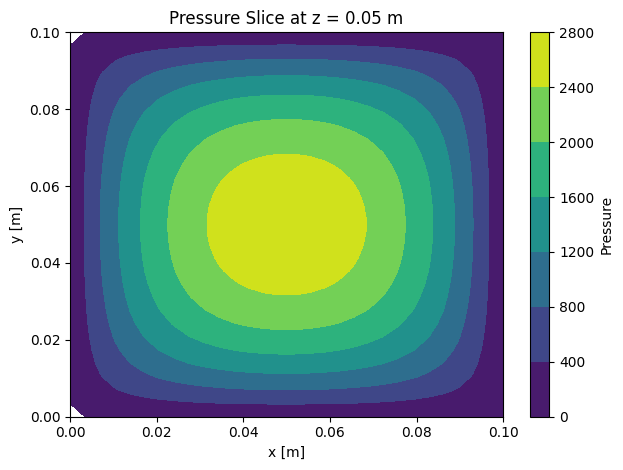

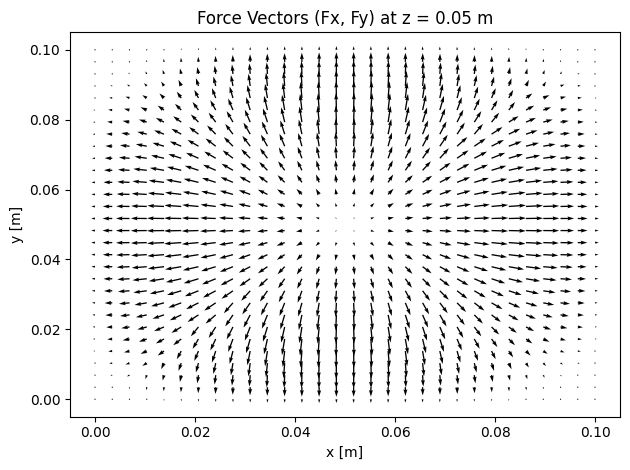

In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt


# ===========================
# 1. MESH AND FUNCTION SPACE
# ===========================
L, H, W = 0.1, 0.1, 0.1  # 10 cm each side
nx, ny, nz = 30, 30, 30
mesh = BoxMesh(Point(0, 0, 0), Point(L, H, W), nx, ny, nz)
V = FunctionSpace(mesh, "P", 1)

# ===============================
# 2. BOUNDARY CONDITION: u = 0
# ===============================
bc = DirichletBC(V, Constant(0.0), "on_boundary")

# ===================================
# 3. TRANSDUCER POSITIONS & AMPLITUDE
# ===================================
transducer_positions = {
    "top": [
        (0.02, 0.02, 0.09), (0.02, 0.08, 0.09), (0.05, 0.05, 0.09),
        (0.08, 0.02, 0.09), (0.08, 0.08, 0.09), (0.02, 0.05, 0.09),
        (0.08, 0.05, 0.09)
    ],
    "left": [
        (0.01, 0.02, 0.05), (0.01, 0.08, 0.05), (0.01, 0.05, 0.02),
        (0.01, 0.05, 0.08)
    ],
    "right": [
        (0.09, 0.02, 0.05), (0.09, 0.08, 0.05), (0.09, 0.05, 0.02),
        (0.09, 0.05, 0.08)
    ]
}

# Uniform amplitude (no time dependence) for each transducer
amplitude = 1.0e6  # example
amplitudes = {key: [amplitude]*len(pos) for key, pos in transducer_positions.items()}

# ==============================
# 4. CUSTOM USER EXPRESSION
#    (Static Transducer Waves)
# ==============================
class StaticTransducerWave(UserExpression):
    def __init__(self, A, px, py, pz, **kwargs):
        super().__init__(**kwargs)
        self.A  = A
        self.px = px
        self.py = py
        self.pz = pz

    def eval(self, value, x):
        """
        Summation of Gaussian sources centered at each transducer.
        NO sinusoidal time factor: purely static.
        """
        val = 0.0
        for i in range(len(self.A)):
            dx = x[0] - self.px[i]
            dy = x[1] - self.py[i]
            dz = x[2] - self.pz[i]
            r2 = dx*dx + dy*dy + dz*dz
            # Example Gaussian "source strength" 
            val += self.A[i] * np.exp(-100.0 * r2)
        value[0] = val

# Make a single expression that sums all transducer sets
wave_expr_sum = None
for key, positions in transducer_positions.items():
    expr = StaticTransducerWave(
        A=amplitudes[key],
        px=[p[0] for p in positions],
        py=[p[1] for p in positions],
        pz=[p[2] for p in positions],
        degree=2
    )
    if wave_expr_sum is None:
        wave_expr_sum = expr
    else:
        # wave_expr_sum + expr is not direct for UserExpression,
        # so we'll just add them in the variational form
        pass

# =============================
# 5. FORM AND SOLVE POISSON EQN
#    -Delta u = wave_expr_sum
# =============================
u = TrialFunction(V)
v = TestFunction(V)

# Left-hand side: ∫ grad(u)·grad(v) dx
a = inner(grad(u), grad(v)) * dx

# Right-hand side: sum of wave_expr(i)*v dx
# We handle multiple sets by adding them up:
rhs = wave_expr_sum * v * dx

u_sol = Function(V)
solve(a == rhs, u_sol, bc, solver_parameters={"linear_solver":"gmres","preconditioner":"ilu"})

# --------------------------------------------------
# 6. GOR’KOV RADIATION FORCE CALCULATION
# --------------------------------------------------
#
# You provided these parameter definitions:

freq   = 40e3        # Frequency, 40 kHz
rho_f  = 1.293       # Density of air (kg/m³)
c_f    = 343         # Speed of sound in air (m/s)
P0     = 1e5         # "Acoustic pressure amplitude" in Pa (but see note below)
k      = 2*np.pi*freq / c_f
a      = 35e-6       # Particle radius (m)
V0     = (4.0/3.0)*np.pi*a**3  # particle volume
rho_p  = 8190        # Density of Inconel 718 (kg/m³)
c_p    = 5894        # Speed of sound in Inconel (m/s)
beta_f = 1/(rho_f*c_f**2)
beta_p = 1/(rho_p*c_p**2)

# Gor'kov coefficients
f1 = 1 - (beta_p/beta_f)
f2 = 2*(rho_p - rho_f)/(2*rho_p + rho_f)

# You might have your own single "Phi" factor, or use f1 & f2 directly.
# For illustration, let's define a simple single factor "Phi" that
# lumps them in one expression. 
# (Yours might differ; check your reference.)
Phi = 0.5  # placeholder or your own function of (f1, f2, etc.)

# =====================
# 6.1. Compute E_ac(x)
# =====================
#
# In a pure traveling or standing wave with amplitude p(x),
# the time-averaged <p^2> is p^2/2 if p is the peak amplitude.
# Then the local acoustic energy density:
#    E_ac(x) = <p^2(x)> / (rho_f * c_f^2)
#            = ( p^2(x)/2 ) / (rho_f * c_f^2 )
#
# Here, "u_sol" is the solution to -Δu = wave_expr_sum, which we're *interpreting*
# as a "pressure" solution. If you prefer, rename "u_sol" to "p_sol".

p_sol = u_sol

# We square p_sol:
p_sq = project(p_sol**2, V)

# Time average factor of 1/2:
E_ac_expr = 0.5 * p_sq / (rho_f * c_f**2)
E_ac = project(E_ac_expr, V)

# =====================================
# 6.2. Construct the Gor’kov potential
#     U(x) = (4π a^3 / 3) * Phi * E_ac(x)
# =====================================
U_expr = (4.0 * np.pi * a**3 / 3.0) * Phi * E_ac
U = project(U_expr, V)

# =====================================
# 6.3. Radiation Force F(x) = -∇U(x)
# =====================================
# 1) Create a DG(0) vector space
V_vector_DG = VectorFunctionSpace(mesh, "DG", 0)

# 2) Project the gradient into that space
grad_U = project(grad(U), V_vector_DG)

# 3) Then if you want F = - grad(U), do:
F = project(-grad_U, V_vector_DG)

# Suppose you have:
#   - u_sol: a Function in "CG", 1 for the "pressure" solution
#   - F:     a Function in "CG", 1 vector space for the "force" (3D vector)

# Choose the slice plane, e.g. z=0.05
z_slice = 0.05

# Decide how many sample points in the x-y directions
Nx, Ny = 30, 30

# Domain extents (match your BoxMesh: 0 <= x <= L, 0 <= y <= H)
L, H = 0.1, 0.1
x_vals = np.linspace(0, L, Nx)
y_vals = np.linspace(0, H, Ny)

# Prepare arrays to store sample values
P_data  = np.zeros((Ny, Nx))   # For the pressure slice
Fx_data = np.zeros((Ny, Nx))   # For the x-component of force
Fy_data = np.zeros((Ny, Nx))   # For the y-component of force
# (We could store Fz as well, but typically quiver is 2D.)

# Sample the solution at each (x_i, y_j, z_slice)
for j in range(Ny):
    for i in range(Nx):
        point = (x_vals[i], y_vals[j], z_slice)
        P_data[j, i] = u_sol(point)  # Pressure at that point
        Fx, Fy, Fz = F(point)        # Force vector
        Fx_data[j, i] = Fx
        Fy_data[j, i] = Fy
        # We ignore Fz for the 2D quiver arrows

# -----------------------------------------------------------
# 2) Plot the PRESSURE as a 2D contour on the (x,y) plane
# -----------------------------------------------------------
X, Y = np.meshgrid(x_vals, y_vals)

plt.figure()
cp = plt.contourf(X, Y, P_data)  # Filled contour of pressure
plt.colorbar(cp, label="Pressure")
plt.title("Pressure Slice at z = 0.05 m")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 3) Plot the FORCE as 2D quiver (Fx, Fy) on same plane
# -----------------------------------------------------------
plt.figure()
plt.quiver(X, Y, Fx_data, Fy_data)
plt.title("Force Vectors (Fx, Fy) at z = 0.05 m")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def create_triangle_mask(Nx, Ny, L, H):
    x_vals = np.linspace(0, L, Nx)
    y_vals = np.linspace(0, H, Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Define triangle vertices (example: centered equilateral triangle)
    v1 = np.array([L/2, H*0.8])       # Top vertex
    v2 = np.array([L*0.2, H*0.2])     # Bottom-left vertex
    v3 = np.array([L*0.8, H*0.2])     # Bottom-right vertex

    def is_inside_triangle(pt, v1, v2, v3):
        d1 = (pt[0]-v2[0])*(v1[1]-v2[1]) - (v1[0]-v2[0])*(pt[1]-v2[1])
        d2 = (pt[0]-v3[0])*(v2[1]-v3[1]) - (v2[0]-v3[0])*(pt[1]-v3[1])
        d3 = (pt[0]-v1[0])*(v3[1]-v1[1]) - (v3[0]-v1[0])*(pt[1]-v1[1])
        has_neg = (d1 < 0) | (d2 < 0) | (d3 < 0)
        has_pos = (d1 > 0) | (d2 > 0) | (d3 > 0)
        return ~(has_neg & has_pos)

    mask = np.zeros((Ny, Nx))
    for i in range(Nx):
        for j in range(Ny):
            pt = np.array([X[j,i], Y[j,i]])
            mask[j,i] = is_inside_triangle(pt, v1, v2, v3)

    return mask


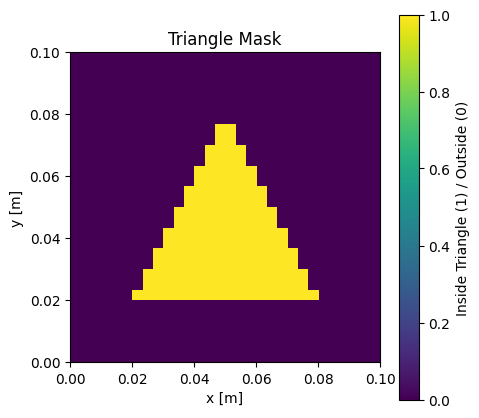

In [2]:
Nx, Ny = 30, 30
L, H = 0.1, 0.1

triangle_mask = create_triangle_mask(Nx, Ny, L, H)

plt.figure(figsize=(5,5))
plt.imshow(triangle_mask, extent=[0,L,0,H], origin='lower')
plt.title('Triangle Mask')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label='Inside Triangle (1) / Outside (0)')
plt.show()
